<a href="https://colab.research.google.com/github/lustea0201/Interpretability/blob/master/HDattempt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
torch.manual_seed(0)
dtype = torch.float
from google.colab import drive
drive.mount('/content/drive/')
import zipfile
import sys
sys.path.append('local_modules')
!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/utils.py -P local_modules -nc
import local_modules.utils as utils

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
File ‘local_modules/utils.py’ already there; not retrieving.



In [0]:
import numpy as np
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision.datasets import ImageFolder
import os
from torch.utils.data import DataLoader

net = utils.Net() # Model instantiation
# Loading the trained dictionnary state
net.load_state_dict(torch.load('drive/My Drive/Interpretability/model2.pth')) 

data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/HD/data2/data.zip", 'r')

root_dir = "main_dir"
data.extractall(root_dir)
data.close()

Batch_Size = 20

MEAN, STD = np.array([0.5, 0.5, 0.5]), np.array([0.5, 0.5, 0.5])

transf = transforms.Compose( [ToTensor(), Normalize(mean=MEAN, std=STD)])

train_data = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transf)
dataloader = DataLoader(train_data, batch_size = Batch_Size, shuffle = True, num_workers = 0)
train_loader = iter(dataloader)

In [3]:
X,y = next(train_loader)

class HD_Net(utils.Net): 
  def __init__(self):
    super().__init__()
  def forward(self, X):
    batch_size = len(X)
    final_output = torch.empty(batch_size, 2)
    
    max_score_1 = -1e9*torch.ones(batch_size)
    for i in range(19): 
      for j in range(19): 
        s_image = X[:,:,i*50:i*50+100, j*60:j*60+120]
        input_ = s_image.reshape(-1, 3, 100, 120) # This shape is necessary for the network 
        output = net(input_)
        _, predicted = torch.max(output.data, 1)
        
        
        score_class_1 = output.data[:,1]
        greater = (score_class_1 > max_score_1)
        max_score_1[greater] = score_class_1[greater]
        final_output[greater] = output[greater]
    return final_output

HDN = HD_Net()
correct = 0

output = HDN(X)
_, predicted = torch.max(output.data, 1)
  
print("Correct: %f percent." % (100*(predicted == y).sum()/len(y)))


Correct: 100.000000 percent.


tensor([1])


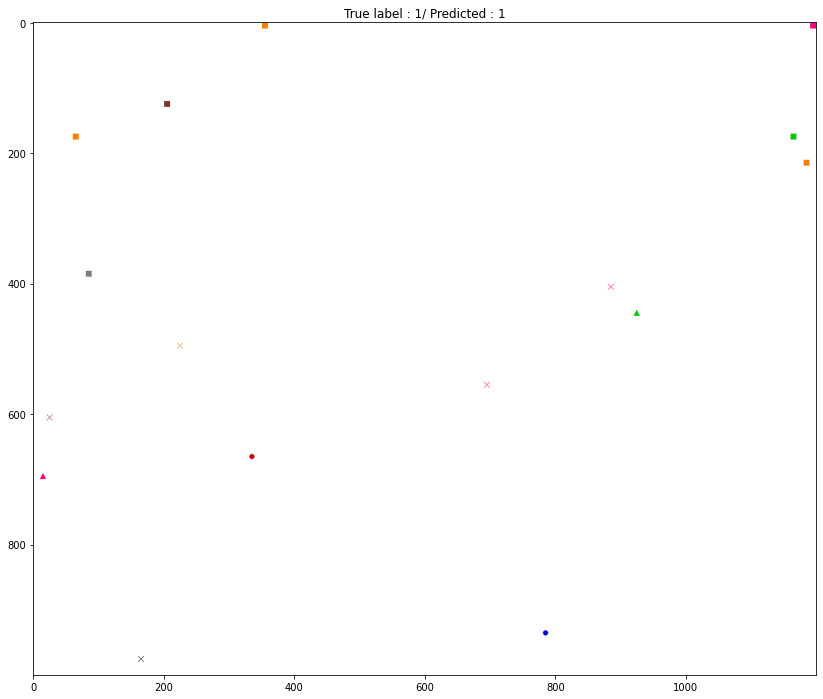

In [4]:
i = 3
image0 = X[i]
label0 = y[i]

input0 = X[i].unsqueeze(0)
output0 = HDN(input0)
_, predicted0 = torch.max(output0.data, 1)
print(predicted0)



img0 = utils.input2image(image0, MEAN, STD)
utils.display_image(img0, label0.numpy(), int(predicted0), figure_size = (16,12))

## SHAP


In [0]:
!pip install shap 
import shap

# For SHAP
bg_choice = "black" # Default: entire training set, "average", "white", "black" 
# Median would result in white 
background = X
if (bg_choice == "black"): 
  background = -torch.ones(X.shape)
elif (bg_choice == "white"): 
  background = torch.ones(X.shape)
elif (bg_choice == "average"): 
  avg = torch.mean(X, dim = 0)
  display_image(avg, 0)
e = shap.GradientExplainer(HDN, background)

In [0]:
!pip install pytorch-gradcam
from torchvision import transforms
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/interpret11.py -P local_modules -nc
import local_modules.interpret11 as intp

intp.shap_exp(e, input0.detach(), img0)

## Hierarchical Shapley

In [5]:
# For Hierarchical 
!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/Hshapley13.py -P local_modules -nc
import local_modules.Hshapley13 as HS

white_bg = -torch.ones(X.shape[1:])
h = HS.HierarchicalShap(HDN, background = white_bg)

File ‘local_modules/Hshapley13.py’ already there; not retrieving.



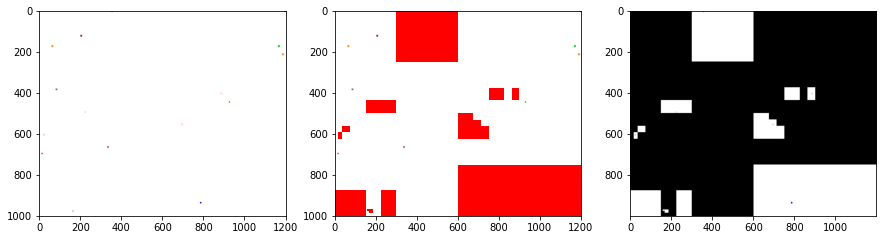

In [6]:
h.shapMap(X[i], y[i], shapTol = [1.5], keepItSimple = True, debug = False)
